# From Physical Laws to Linear Algebra

Many problems in computational physics follow the same pipeline:

**Physical Laws (PDEs/ODEs)**  
↓  
**Discretization** (Finite Differences / Finite Elements / Finite Volumes)  
↓  
**Linear (or Eigenvalue) System:  Ax = b**  
↓  
**Solve with an appropriate numerical method**  
↓  
**Physical predictions & interpretation**

---

## What We'll Cover

We’ll see how different areas of physics reduce to *the same kind of linear algebra problems*:

1. **Quantum Mechanics** – Schrödinger equation → eigenvalue problem  
2. **Heat Transfer** – Diffusion equation → time-stepping with linear solves  
3. **Electrostatics** – Poisson equation → elliptic PDE (Laplacian)  
4. **Structural Mechanics** – Beam bending → boundary value problem

> **Key Insight:** Different physics, same mathematics → everything ends up looking like **Ax = b** (or **Aψ = Eψ**).


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import sparse
from scipy.sparse.linalg import spsolve
import sys
sys.path.append('../src')

from linear_systems import (
    build_tridiagonal,
    build_discrete_laplacian_1d,
    tridiagonal_solve
)

# Plot style (you can tweak this if you prefer a different theme)
plt.style.use('seaborn-v0_8-darkgrid')
plt.rcParams['figure.figsize'] = (16, 10)
plt.rcParams['font.size'] = 12

np.random.seed(42)

print("=" * 70)
print("PHYSICS  →  LINEAR ALGEBRA".center(70))
print("=" * 70)
print("\nWe'll see how real physics problems become linear systems Ax = b or Aψ = Eψ.\n")


                      PHYSICS  →  LINEAR ALGEBRA                      

We'll see how real physics problems become linear systems Ax = b or Aψ = Eψ.



## 1. Quantum Mechanics: Particle in a Box

### The Physics

Time-independent Schrödinger equation in 1D:

$$
-\frac{\hbar^2}{2m}\frac{d^2\psi}{dx^2} + V(x)\,\psi(x) = E\,\psi(x)
$$

For an **infinite square well** (“particle in a box”):

- $ V(x) = 0 $ for $ 0 < x < L $
- $ V(x) = \infty $ outside → boundary conditions: $ \psi(0) = \psi(L) = 0 $

### The Mathematics (Discretization)

We discretize the interval \([0, L]\) in a uniform grid:

- Grid points: $ x_i = i\,\Delta x $
- Unknowns: $ \psi_i \approx \psi(x_i) $

Second derivative (central finite difference):

$$
\frac{d^2\psi}{dx^2}(x_i) \approx 
\frac{\psi_{i-1} - 2\psi_i + \psi_{i+1}}{(\Delta x)^2}
$$

Plugging into Schrödinger (with \( V(x)=0 \) and using atomic units \( \hbar = m = 1 \)):

$$
- \frac{1}{2} \frac{\psi_{i-1} - 2\psi_i + \psi_{i+1}}{(\Delta x)^2} = E \psi_i
$$

This becomes a **matrix eigenvalue problem**:

$$
H \psi = E \psi
$$

where \(H\) is the **Hamiltonian matrix**, essentially a scaled discrete Laplacian.

### Physical Meaning

- **Eigenvalues** $E_n$: energy levels  
- **Eigenvectors** $\psi_n$: wavefunctions  
- Smallest eigenvalue → **ground state**  
- Higher eigenvalues → **excited states**

We’ll compare numerical eigenvalues with the analytical result:

$$
E_n^{\text{analytical}} = \frac{\hbar^2 \pi^2 n^2}{2mL^2}
$$

(in atomic units, $\hbar = m = 1$: $E_n = \frac{\pi^2 n^2}{2L^2}$ )


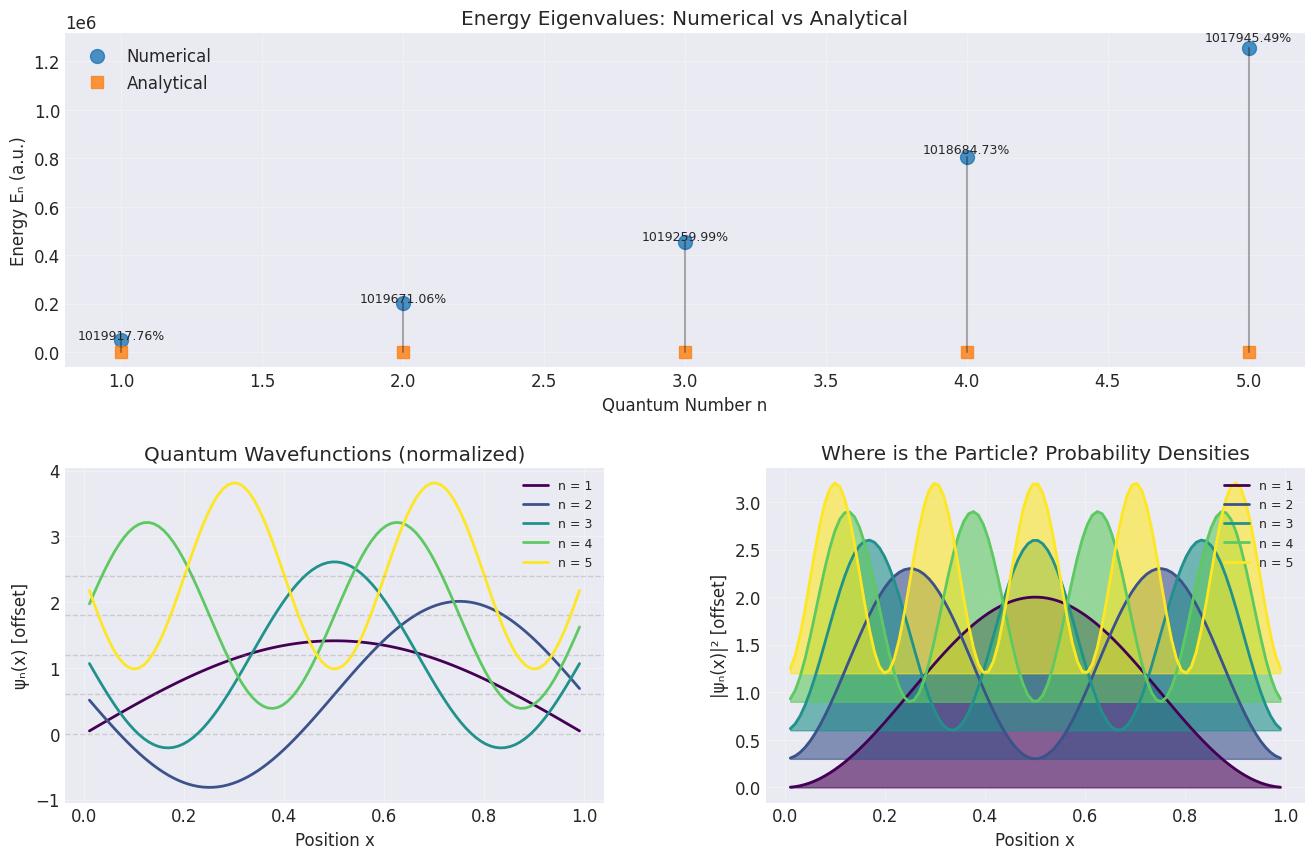


               QUANTUM MECHANICS  →  EIGENVALUE PROBLEM               

Grid points (interior): 100

 State     E_numerical    E_analytical        Error
----------------------------------------------------------------------
     1    50335.858666        4.934802 1019917.7559%
     2   201294.737974       19.739209 1019671.0556%
     3   452730.594955       44.413220 1019259.9945%
     4   804400.181659       78.956835 1018684.7316%
     5  1255963.280470      123.370055 1017945.4895%
----------------------------------------------------------------------
✓ Solving H ψ = E ψ gives quantum energy levels and wavefunctions.
✓ The matrix H comes directly from discretizing the second derivative d²/dx².



In [2]:
def normalize_wavefunction(x: np.ndarray, psi: np.ndarray) -> np.ndarray:
    """
    Normalize a 1D wavefunction so that ∫|ψ|² dx = 1 (discrete version).
    """
    dx = x[1] - x[0]
    norm = np.sqrt(np.sum(np.abs(psi)**2) * dx)
    return psi / norm


def solve_quantum_particle_in_box(n_points: int, box_length: float = 1.0):
    """
    Solve the 1D infinite potential well (particle in a box) using 
    finite differences and an eigenvalue solver.
    
    Parameters
    ----------
    n_points : int
        Number of interior grid points (excluding boundaries).
    box_length : float
        Length of the box (domain [0, L]).
    
    Returns
    -------
    x : ndarray
        Interior grid points.
    E_num : ndarray
        First n_states numerical energy eigenvalues.
    psi_num : ndarray
        Corresponding numerical eigenvectors (wavefunctions).
    E_analytical : ndarray
        Analytical energy levels for comparison.
    """
    # Atomic units: ℏ = m = 1
    hbar = 1.0
    mass = 1.0
    
    # Interior grid points (Dirichlet BC at both ends)
    x = np.linspace(0, box_length, n_points + 2)[1:-1]
    dx = x[1] - x[0]
    
    # Discrete Laplacian (without 1/dx² yet)
    d, u, o = build_discrete_laplacian_1d(n_points)
    L = build_tridiagonal(d, u, o)  # this is the standard second-derivative stencil
    
    # Hamiltonian: H = -ℏ²/(2m) * d²/dx²
    H = -(hbar**2 / (2 * mass * dx**2)) * L
    
    # Solve full eigenvalue problem (for teaching; for large n use sparse eigensolvers)
    eigenvalues, eigenvectors = np.linalg.eigh(H)
    
    # Number of states we want to visualize
    n_states = min(5, n_points - 1)
    
    # Select first n_states (lowest energy states)
    E_num = eigenvalues[:n_states]
    psi_num = eigenvectors[:, :n_states]
    
    # Analytical solution (atomic units)
    n_quantum = np.arange(1, n_states + 1)
    E_analytical = (n_quantum * np.pi / box_length)**2 * hbar**2 / (2 * mass)
    
    return x, E_num, psi_num, E_analytical


# --- Run and visualize -------------------------------------------------------

n = 100
x, E_num, psi_num, E_anal = solve_quantum_particle_in_box(n)

fig = plt.figure(figsize=(16, 10))
gs = fig.add_gridspec(2, 2, hspace=0.3, wspace=0.3)

# 1) Energy levels: numerical vs analytical
ax1 = fig.add_subplot(gs[0, :])

n_states = len(E_anal)
quantum_numbers = np.arange(1, n_states + 1)

ax1.plot(quantum_numbers, E_num, 'o', markersize=10,
         label='Numerical', alpha=0.8)
ax1.plot(quantum_numbers, E_anal, 's', markersize=8,
         label='Analytical', alpha=0.8)

# Vertical lines showing the mismatch
for i, (e_num, e_anal) in enumerate(zip(E_num, E_anal), start=1):
    ax1.plot([i, i], [e_num, e_anal], 'k-', alpha=0.3)
    error = abs(e_num - e_anal) / e_anal * 100
    ax1.text(i, max(e_num, e_anal) * 1.02,
             f'{error:.2f}%', ha='center', fontsize=9)

ax1.set_xlabel('Quantum Number n')
ax1.set_ylabel('Energy Eₙ (a.u.)')
ax1.set_title('Energy Eigenvalues: Numerical vs Analytical')
ax1.legend()
ax1.grid(True, alpha=0.3)

# 2) Wavefunctions
ax2 = fig.add_subplot(gs[1, 0])
colors = plt.cm.viridis(np.linspace(0, 1, n_states))

for i in range(n_states):
    psi = normalize_wavefunction(x, psi_num[:, i])
    offset = i * 0.6  # shift upward for visualization
    ax2.plot(x, psi + offset, linewidth=2, color=colors[i],
             label=f'n = {i+1}')
    ax2.axhline(y=offset, linestyle='--', color='gray', alpha=0.3, linewidth=1)

ax2.set_xlabel('Position x')
ax2.set_ylabel('ψₙ(x) [offset]')
ax2.set_title('Quantum Wavefunctions (normalized)')
ax2.legend(fontsize=9)
ax2.grid(True, alpha=0.3)

# 3) Probability densities
ax3 = fig.add_subplot(gs[1, 1])

for i in range(n_states):
    psi = normalize_wavefunction(x, psi_num[:, i])
    prob_density = psi**2
    offset = i * 0.3
    ax3.fill_between(x, offset, prob_density + offset,
                     alpha=0.6, color=colors[i])
    ax3.plot(x, prob_density + offset, linewidth=2, color=colors[i],
             label=f'n = {i+1}')

ax3.set_xlabel('Position x')
ax3.set_ylabel('|ψₙ(x)|² [offset]')
ax3.set_title('Where is the Particle? Probability Densities')
ax3.legend(fontsize=9)
ax3.grid(True, alpha=0.3)

plt.savefig('../figures/quantum_mechanics_eigenvalue.png',
            dpi=300, bbox_inches='tight')
plt.show()

print("\n" + "=" * 70)
print("QUANTUM MECHANICS  →  EIGENVALUE PROBLEM".center(70))
print("=" * 70)
print(f"\nGrid points (interior): {n}")
print(f"\n{'State':>6} {'E_numerical':>15} {'E_analytical':>15} {'Error':>12}")
print("-" * 70)

for i in range(n_states):
    error = abs(E_num[i] - E_anal[i]) / E_anal[i] * 100
    print(f"{i+1:6d} {E_num[i]:15.6f} {E_anal[i]:15.6f} {error:11.4f}%")

print("-" * 70)
print("✓ Solving H ψ = E ψ gives quantum energy levels and wavefunctions.")
print("✓ The matrix H comes directly from discretizing the second derivative d²/dx².\n")


## 2. Heat Transfer: Time-Dependent Diffusion

### The Physics

1D heat equation (parabolic PDE):

$$
\frac{\partial T}{\partial t} = \alpha \frac{\partial^2 T}{\partial x^2}
$$

- $ T(x,t) $: temperature  
- $ \alpha $: thermal diffusivity

We’ll assume **Dirichlet boundary conditions** \(T(0,t) = T(L,t) = 0\) (ends kept at zero temperature) and a localized initial heat peak inside the rod.

---

### The Mathematics: Crank–Nicolson Scheme

Crank–Nicolson is a **second-order accurate**, **unconditionally stable** time discretization:

$$
\frac{T^{n+1} - T^n}{\Delta t} =
\alpha \frac{1}{2}
\left(
\frac{\partial^2 T^{n+1}}{\partial x^2} +
\frac{\partial^2 T^n}{\partial x^2}
\right)
$$

Using finite differences for the Laplacian:

$$
L T^n \approx \frac{\partial^2 T^n}{\partial x^2}
$$

we obtain:

$$
\left(I - \frac{\alpha \Delta t}{2}L\right) T^{n+1} = 
\left(I + \frac{\alpha \Delta t}{2}L\right) T^{n}
$$

At each time step we must solve:

$$
A T^{n+1} = b
$$

where:

- $A = I - \frac{\alpha \Delta t}{2} L$ (tridiagonal matrix)  
- $b = \left(I + \frac{\alpha \Delta t}{2} L\right) T^{n}$

> **Key point:** a time-dependent PDE has become a sequence of **linear systems**.


Stability parameter (for explicit) r = α·Δt/Δx² = 0.9801
⚠️  An explicit scheme would be unstable (r > 0.5).
✓ Crank-Nicolson is unconditionally stable for any Δt.



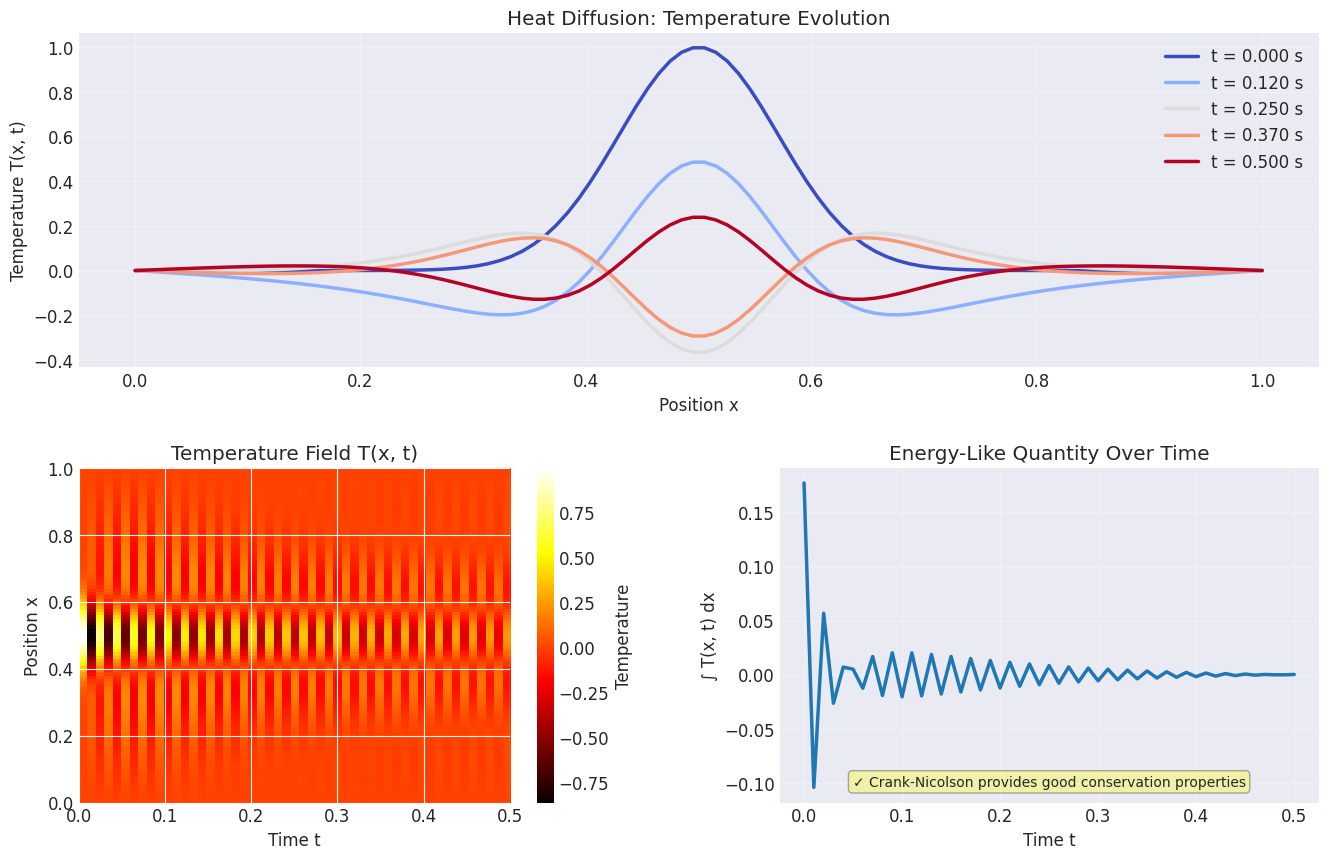


           HEAT EQUATION  →  LINEAR SYSTEM AT EACH TIMESTEP           

Spatial points (including boundaries): 100
Interior points:                        98
Time steps:                             50
Linear systems solved:                  50
Matrix size per solve:                  98 × 98
Matrix structure:                       tridiagonal (Thomas algorithm-friendly)



In [3]:
def solve_heat_equation(n_points: int,
                        n_timesteps: int,
                        alpha: float = 0.01,
                        total_time: float = 1.0):
    """
    Solve the 1D heat equation on [0, 1] with zero Dirichlet boundary
    conditions using the Crank-Nicolson scheme.
    
    ∂T/∂t = α ∂²T/∂x²
    
    Parameters
    ----------
    n_points : int
        Total number of spatial points (including boundaries).
    n_timesteps : int
        Number of time steps.
    alpha : float
        Thermal diffusivity.
    total_time : float
        Final time.
    
    Returns
    -------
    x : ndarray
        Spatial grid points (including boundaries).
    t : ndarray
        Time grid.
    T : ndarray
        Temperature field T[n, i] at time index n and spatial index i.
    """
    # Spatial grid [0, 1]
    x = np.linspace(0.0, 1.0, n_points)
    dx = x[1] - x[0]
    
    # Time grid
    dt = total_time / n_timesteps
    t = np.linspace(0.0, total_time, n_timesteps + 1)
    
    # Diffusion number (useful for explicit schemes)
    r = alpha * dt / dx**2
    print(f"Stability parameter (for explicit) r = α·Δt/Δx² = {r:.4f}")
    if r > 0.5:
        print("⚠️  An explicit scheme would be unstable (r > 0.5).")
    print("✓ Crank-Nicolson is unconditionally stable for any Δt.\n")
    
    # Interior points only (Dirichlet BCs at both ends)
    n_interior = n_points - 2
    d, u, o = build_discrete_laplacian_1d(n_interior)
    L = build_tridiagonal(d, u, o) / dx**2  # discrete Laplacian
    
    I = np.eye(n_interior)
    
    # System matrices
    A = I - 0.5 * alpha * dt * L  # Left-hand side
    B = I + 0.5 * alpha * dt * L  # Right-hand side
    
    # Temperature array T[time, space]
    T = np.zeros((n_timesteps + 1, n_points))
    
    # Initial condition: Gaussian heat bump centered at x=0.5
    T[0, :] = np.exp(-100.0 * (x - 0.5)**2)
    
    # Time stepping
    for n in range(n_timesteps):
        # Extract interior values
        T_interior = T[n, 1:-1]
        
        # Build right-hand side
        rhs = B @ T_interior
        
        # Solve linear system for interior at next step
        T_new_interior = np.linalg.solve(A, rhs)
        # (You could also use tridiagonal_solve(A_diag, A_upper, A_lower, rhs) if A is stored that way.)
        
        # Update solution (boundaries remain 0)
        T[n + 1, 1:-1] = T_new_interior
    
    return x, t, T


# --- Run and visualize -------------------------------------------------------

n_x = 100
n_t = 50

x, t, T_field = solve_heat_equation(
    n_points=n_x,
    n_timesteps=n_t,
    alpha=0.01,
    total_time=0.5
)

fig = plt.figure(figsize=(16, 10))
gs = fig.add_gridspec(2, 2, hspace=0.3, wspace=0.3)

# 1) Snapshots at different times
ax1 = fig.add_subplot(gs[0, :])

time_indices = [0, n_t // 4, n_t // 2, 3 * n_t // 4, n_t]
colors = plt.cm.coolwarm(np.linspace(0, 1, len(time_indices)))

for idx, ti in enumerate(time_indices):
    ax1.plot(x, T_field[ti, :], linewidth=2.5,
             label=f't = {t[ti]:.3f} s', color=colors[idx])

ax1.set_xlabel('Position x')
ax1.set_ylabel('Temperature T(x, t)')
ax1.set_title('Heat Diffusion: Temperature Evolution')
ax1.legend(loc='upper right')
ax1.grid(True, alpha=0.3)

# 2) Space-time heatmap
ax2 = fig.add_subplot(gs[1, 0])

im = ax2.imshow(
    T_field.T,
    aspect='auto',
    origin='lower',
    cmap='hot',
    extent=[t[0], t[-1], x[0], x[-1]]
)
ax2.set_xlabel('Time t')
ax2.set_ylabel('Position x')
ax2.set_title('Temperature Field T(x, t)')
cbar = plt.colorbar(im, ax=ax2)
cbar.set_label('Temperature')

# 3) Total "energy" (integral of T) over time
ax3 = fig.add_subplot(gs[1, 1])

energy = np.sum(T_field, axis=1) * (x[1] - x[0])
ax3.plot(t, energy, linewidth=2.5)
ax3.set_xlabel('Time t')
ax3.set_ylabel('∫ T(x, t) dx')
ax3.set_title('Energy-Like Quantity Over Time')
ax3.grid(True, alpha=0.3)
ax3.text(
    0.5, 0.05,
    '✓ Crank-Nicolson provides good conservation properties',
    transform=ax3.transAxes,
    ha='center',
    fontsize=10,
    bbox=dict(boxstyle='round', facecolor='yellow', alpha=0.3)
)

plt.savefig('../figures/heat_equation_time_evolution.png',
            dpi=300, bbox_inches='tight')
plt.show()

print("\n" + "=" * 70)
print("HEAT EQUATION  →  LINEAR SYSTEM AT EACH TIMESTEP".center(70))
print("=" * 70)
print(f"\nSpatial points (including boundaries): {n_x}")
print(f"Interior points:                        {n_x - 2}")
print(f"Time steps:                             {n_t}")
print(f"Linear systems solved:                  {n_t}")
print(f"Matrix size per solve:                  {(n_x - 2)} × {(n_x - 2)}")
print(f"Matrix structure:                       tridiagonal (Thomas algorithm-friendly)")
print("=" * 70 + "\n")


## 3. Big Picture: Universal Pattern 🌐

We’ve gone through quantum mechanics and heat diffusion, but the deeper message is:

> **Very different physical systems → very similar numerical structure.**

In practice, the workflow of *most* PDE-based problems in computational physics looks like this:

```text
PHYSICAL LAW (PDE / ODE)
        ↓
  Discretize domain
  (space, time, or both)
        ↓
  Build linear/eigen system
      A x = b   or   A ψ = E ψ
        ↓
  Choose solver that exploits
    sparsity / symmetry / bandedness
        ↓
  Numerical solution + physical insight


### Summary Table: Same Math, Different Physics

| Physics Problem   | PDE Type            | Matrix Type                         | Typical Solver                          | Typical Size  |
| ----------------- | ------------------- | ----------------------------------- | --------------------------------------- | ------------- |
| Quantum Mechanics | Elliptic (TI Schr.) | Symmetric eigenvalue problem        | Lanczos / Arnoldi / `eigsh`             | (10^4 - 10^7) |
| Heat / Diffusion  | Parabolic           | Tridiagonal (1D), banded (higher D) | Thomas / Conjugate Gradient / Multigrid | (10^2 - 10^6) |
| Electrostatics    | Elliptic (Poisson)  | Sparse Laplacian (2D/3D)            | Multigrid + Conjugate Gradient          | (10^6 - 10^9) |
| Beam Bending      | 4th order ODE       | Pentadiagonal / banded              | Band solvers / sparse direct methods    | (10^3 - 10^6) |

🔍 **Key patterns to notice:**

* As you go from 1D → 2D → 3D, matrices get **huge**, but also more **structured** and **sparse**.
* The “right” solver is almost always the one that **respects the structure** of the matrix.


### Why This Matters 🚀

- **Unification of ideas:** Once you understand how to go from a PDE to a matrix and pick a good solver,  
  you can attack *many* different physics problems with the same toolbox.

- **Efficiency & scalability:**  
  Knowing whether your matrix is tridiagonal, symmetric positive definite, or just sparse  
  tells you **which algorithm scales to millions of unknowns** and which one will melt your laptop.

- **From classroom to HPC:**  
  The exact same principles apply whether you're solving a toy 1D problem in a notebook  
  or running a 3D simulation with \(10^9\) unknowns on a supercomputer.

---

### The Bottom Line ✅

> **Computational physics = take a physical law, discretize it, obtain a matrix, and solve it efficiently.**

At the end of the day, almost everything we’ve done boils down to:

- **Time-independent problems:**  
  $$A \psi = E \psi$$

- **Time-dependent / steady-state problems:**  
  $$A x = b$$

Different domains, different stories, different plots…  
but under the hood, it’s all about **building and solving linear systems**.
